# Prova 1 (2°/2019)
## DPEE805 - Modelagem e Controle de Conversores
### Prof° Cassiano Rech | Acadêmico: Tiarles da Rocha Moralles Guterres

#### Informações gerais sobre este arquivo:
Este arquivo é um formato impresso de um ambiente em Python chamado Jupyter-notebook. Com o Jupyter-notebook você pode escrever código e documentá-lo simultaneamente, intercalando no que chamamos de células de código, em Python, e células de texto.

#### Um pouco sobre sintaxe:
Python, diferente de MATLAB, não existe um direcionamento específico para cálculos matriciais e modelagem. Porém, utilizando alguns repositórios (também chamados de módulos) podemos realizar quase todos os procedimentos feitos em MATLAB de forma bem simples. Python e seus pacotes são *open source*.

Os módulos utilizados neste notebook e importados na célula abaixo são:
* **pandas**: Para a leitura de arquivos ``.csv``.
* **matplotlib.pyplot**: Para a geração de figuras a partir de vetores.
* **numpy**: É a biblioteca numérica de Python, onde estão implementadas as estruturas e operações com vetores/matrizes.
* **scipy.signal**: Biblioteca para análise e reposta de sinais em vários domínios.

In [1]:
from pandas import read_csv
from matplotlib.pyplot import figure, plot, subplot, grid, legend, show, savefig
from numpy import array, identity, zeros, dot, ones, arange
from numpy.linalg import inv
from scipy.signal import StateSpace, lsim

<a id='step_function'></a>

Abaixo a função para simular o bloco de *step* do Simulink é declarada:

In [175]:
def step(t, t_step, y_inital, y_final, nome):
    ret = ones(t.size)
    
    yt_initial = t < t_step
    ret[yt_initial] = y_inital
    
    yt_final = t >= t_step
    ret[yt_final] = y_final
    
    figure(figsize=(5,1))
    plot(t, ret, label=nome)
    legend()
    show()

    return ret

Na célula abaixo, o arquivo com as ondas do PSIM é importado, algumas configurações são realizadas e é possível ver as primeiras e últimas amostras do arquivo:

In [4]:
df = read_csv('ex2_prova.csv') # Aqui ocorre a importação do arquivo .csv

# E aqui a coluna que mostra o tempo instantâneo de cada amostra é setado como o indíce desta tabela
df = df.set_index('Time')

df

,I(Le),I(L),Vc
Time,,,
0.000001,0.166577,-0.014980,0.002724
0.000002,0.333028,-0.029931,0.009076
0.000003,0.499382,-0.044861,0.018148
0.000004,0.665602,-0.059759,0.030844
0.000005,0.831682,-0.074624,0.047161
...,...,...,...
0.049996,23.539100,35.316200,96.367900
0.049997,23.541100,35.330500,96.149500
0.049998,23.543500,35.344800,95.930800


Abaixo cada uma das colunas de interesse são inseridas em variáveis diferentes para, mais tarde, compararmos com o modelo matemático calculado em espaço de estados:

In [7]:
iLe = df['I(Le)']
Vc = df['Vc']
IL = df['I(L)']

E as correntes nos indutores e as tensões dos capacitores do **modelo físico** podem ser visualizados.

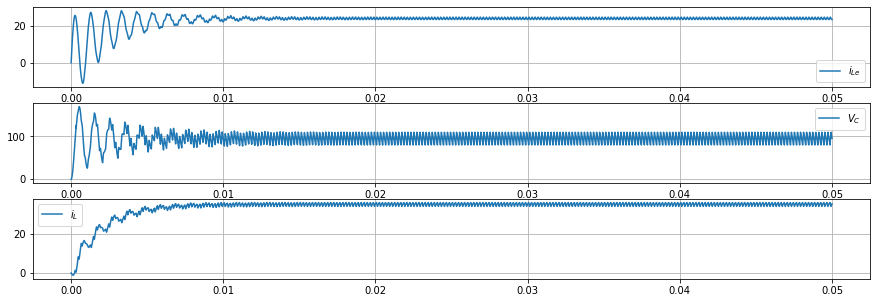

In [9]:
figure(figsize=(15, 5))
subplot(311)
plot(iLe, label='$i_{Le}$')
# plot(iL2, label='$i_{L2}$')
legend()
grid()
subplot(312)
plot(Vc, label='$V_{C}$')
# plot(vC2, label='$V_{C2}$')
legend()
grid()
subplot(313)
plot(IL, label='$i_{L}$')
# plot(vC2, label='$V_{C2}$')
legend()
grid()
savefig('1_ondas_PSIM.png')
show()

#### Modelagem no espaço de estados

O tempo de simulação (``t_final``), a taxa de amostragem (``t_step``), os valores dos componentes (``L1``, ``L2``, ``Cap1``, ``Cap2`` e ``R``), a fonte de entrada (``Vin``), o *duty-cycle* (``D``), a pertubação de *duty-cycle* ($\hat{d}$ = ``d_f``) e a pertubação na fonte de entrada ($\hat{u}$ = ``v_f``) foram configurados abaixo:

In [16]:
t_step = 1e-6
t_final = .05

Le = .6e-3
L = 2e-3
Cap = 500e-6
R = 1; RC = .2; RL = .2
Vg = 100
Vgc = 30
D = 0.4

E, como no arquivo ``aula_buckboost.m`` as matrizes para a modelagem são montadas:

In [17]:
K = array([[Le,   0,  0], 
            [0, Cap,  0],
            [0,   0,  L]])

**Primeira** Etapa do conversor (**ON**)

In [33]:
A1 = array([[-RC-RL, -1,    RC],
            [     1,  0,    -1],
            [    RC,  1, -R-RC]])
B1 = array([[1, 0,  0],
            [0, 0, -1]]).transpose()
C1 = identity(3)
E1 = zeros((3, 2))

**Segunda** Etapa do conversor (**OFF**)

In [34]:
A2 = array([[-RC-RL, -1,  0],
            [     1,  0,  0],
            [     0,  0, -R]])
B2 = array([[1, 0,  0],
            [0, 0, -1]]).transpose()
C2 = identity(3)
E2 = zeros((3, 2))

As matrizes médias:

In [165]:
A = D*A1 + (1-D)*A2
B = D*B1 + (1-D)*B2
C = D*C1 + (1-D)*C2
E = D*E1 + (1-D)*E2
B

array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.]])

Os valores em regime permanente. (Para a computação correta do produto escalar é utilizada a função ``dot``):

In [138]:
U = matrix([Vg, Vgc]).transpose()
X = -inv(A) @ B @ U
Y = (-C @ inv(A) @ B + E) @ U

Matrizes padrão para representação do modelo CA em espaço de estados

In [139]:
Ap = inv(K)@A
print(Ap)

[[ -666.66666667 -1666.66666667   133.33333333]
 [ 2000.             0.          -800.        ]
 [   40.           200.          -540.        ]]


Devido a sintaxe de Python as matrizes ``Bp`` e ``Ep``, que contém as componentes que multiplicam $\hat{d}$ e $\hat{u}$, necessitam ser transpostas:

In [140]:
from numpy import hstack
Bp = hstack([inv(K) @ B, 
         inv(K) @ ((A1-A2) @ X + (B1-B2) @ U)])
print(Bp)

[[  1666.66666667      0.           3086.41975309]
 [     0.              0.         -18518.51851852]
 [     0.           -500.          49074.07407407]]


In [141]:
Cp = C
print(Cp)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [145]:
Ep = hstack([E, (C1-C2) @ X + (E1-E2) @ U])

print(Ep)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Com as matrizes ``Ap``, ``Bp``, ``Cp``, ``Ep`` calculadas o modelo de espaço de estado é montado (a partir daqui o notebook assume o que o ``buckboost.mdl`` no Simulink faz)

In [146]:
ss_buckboost = StateSpace(Ap, Bp, Cp, Ep)

Um sinal de tempo (``t_in``) e os steps de entrada (``u`` e ``d``) são gerados utilizando a função [step](#step_function) criada.

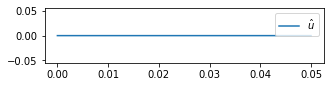

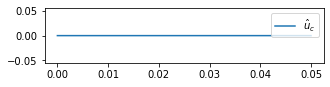

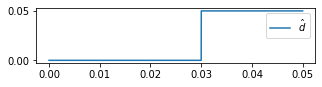

In [176]:
d_f = .05
v_f = 0
vc_f = 0

t_in = arange(0, t_final, t_step)

u = step(t_in, .03, 0, v_f, '$\hat{u}$')
uc = step(t_in, .03, 0, vc_f, '$\hat{u}_c$')
d = step(t_in, .03, 0, d_f, '$\hat{d}$')

up = array([u, uc, d]).transpose()

Nesse momento, com as entradas definidas e o modelo pronto podemos evolui-lo no espaço de estados utilizando a função ``lsim``:

In [177]:
t, y1, _ = lsim(ss_buckboost, up, T=t_in)

E a resposta do modelo pertubado é somado com a saída ``Y``:

In [192]:
iLe_ss = array(y1[:,0] + Y[0])[0]
Vc_ss  = array(y1[:,1] + Y[1])[0]
iL_ss  = array(y1[:,2] + Y[2])[0]

A figura abaixo mostra o modelo obtido para as medidas de interesse:

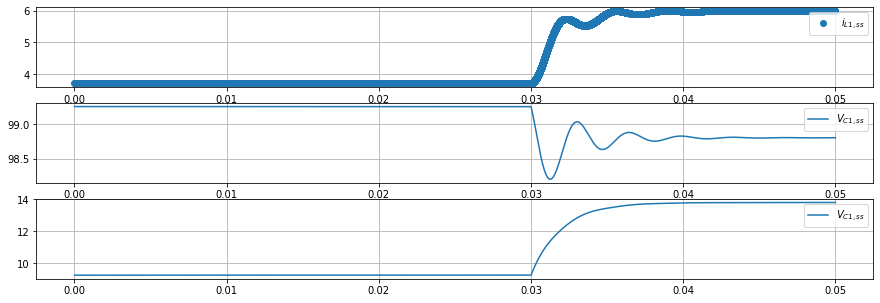

In [193]:
figure(figsize=(15, 5))

subplot(311)
plot(t, iLe_ss, 'o', label='$i_{L1, ss}$')
# plot(t, iL2_ss, 'o', label='$i_{L2, ss}$')
legend()
grid()

subplot(312)
plot(t, Vc_ss, label='$V_{C1, ss}$')
# plot(t, vC2_ss, label='$V_{C2, ss}$')
legend()
grid()

subplot(313)
plot(t, iL_ss, label='$V_{C1, ss}$')
# plot(t, vC2_ss, label='$V_{C2, ss}$')
legend()
grid()

savefig('2_ondas_Matematico.png')
show()

E por fim, o modelo de espaço de estados é comparado com o modelo físico:

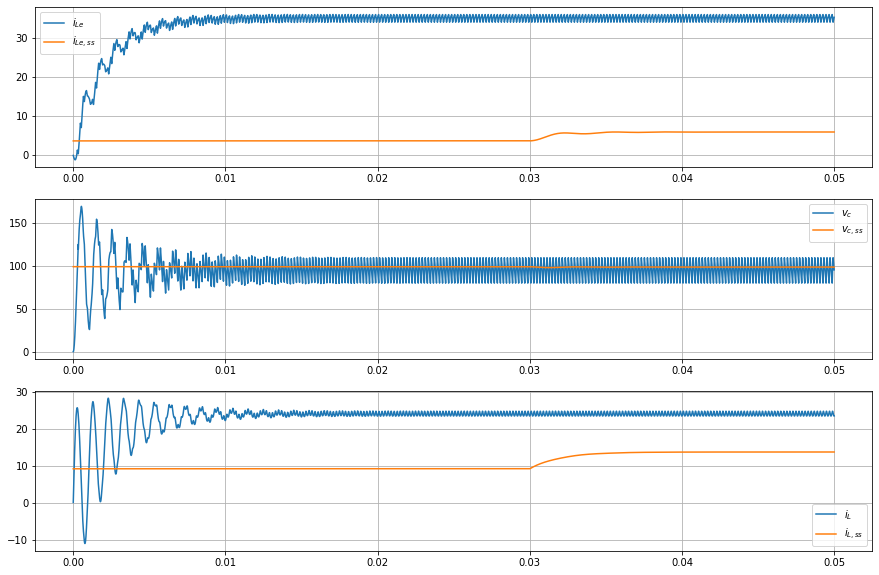

In [202]:
figure(figsize=(15, 10))

subplot(311)
plot(df.index, iLe, label='$i_{Le}$')
plot(t, iLe_ss, label='$i_{Le, ss}$')
legend()
grid()

subplot(312)
plot(df.index, Vc, label='$v_{c}$')
plot(t, Vc_ss, label='$v_{c, ss}$')

legend()
grid()

subplot(313)
plot(df.index, IL, label='$i_{L}$')
plot(t, iL_ss, label='$i_{L, ss}$')
legend()
grid()

savefig('3_comparacao_modelos.png')

show()

## Geração da Função de Transferência

Devido algumas diferenças toleráveis na computação de valores muito grandes os arrays com numeradores e o denominadores gerados foram **arredondados para 6 casas decimais**. Isto deixa mais clara a representação da função de transferência.

In [58]:
from scipy.signal import ss2tf
from control import tf
from numpy import around

In [59]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,0)

n_of_decimals = 6
num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [60]:
print(Gi_vg)
print(Gv_vg)


    1000 s^3 + 2e+06 s^2 + 1.16e+10 s + 3.2e+12
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14


                  4e+09 s + 8e+12
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14



In [61]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,1)

num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [62]:
print(Gi_vg)
print(Gv_vg)


      3.84e+07 s^2 + 2.688e+11 s + 7.68e+14
--------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14


4.8e+04 s^3 + 8.064e+07 s^2 + 4.493e+11 s + 9.6e+14
---------------------------------------------------
s^4 + 2000 s^3 + 2.16e+07 s^2 + 2.32e+10 s + 1e+14

